# Earthquake Data Analysis

The project consists of analyzing a dataset (called also "catalog") of earthquakes collected in about 20 years of recording in South California.

The catalog includes the magnitude, time of occurrence (s), and 3D coordinates (m) of earthquakes. Coordinates were converted from latitude, longitude, and depth of events in a seismic catalog. Magnitudes should be within the range $[0,8]$.

* __Waiting time (t)__: time interval between an event and the next one in the sequence.
* __Distance (r)__: Euclidean 3D distance between events (each 3D set of coordinates refers to the hypocenter, i.e. the point triggering the slip in a fault that forms the earthquake).

## Data

The catalog `SouthCalifornia-1982-2011.dat` is a data file with the following content:

* column 1: index of the event
* column 2: index of the previous event that triggered it (defined with a given algorithm), -1 if no ancestor is found
* column 3: time (seconds) from 0:00 of Jan.1st, 1982
* column 4: magnitude
* columns 5, 6, and 7: 3D coordinates (in meters) of the earthquake hypocenter, i.e. of the point from where it started. These Euclidean coordinates are derived from latitude, longitude and depth.

By joining each event to that with the index of the second column (if not -1), a set of causal trees would emerge.


## Assignments

1. Visualize the process in space and/or time with a suitable time series and/or 3D visualizations of the hypocenters. For instance, plot a space variable (a single coordinate or an appropriate linear combination of coordinates) as a function of time.
2. Compute the distribution $P_m(t)$ of waiting times for events of magnitude $m$ or above (i.e. do not consider events below $m$). In shaping the bin sizes, take into account that this distribution is expected to have a power-law decay with time (e.g $\sim 1/t$), and that a power-law is well visualized in log-log scale. Do this analysis for many values of $m$, say $m=2,3,4,5$. If deemed appropriate, choose a function and fit it to the data.
3. Compute the distribution $P_m(r)$ of the distance between an event and the next one, considering earthquakes of magnitude $m$ or above. Make a clever choice for the bin sizes, and try several values of $m$. Fit the data with an appropriate function, if possible.
4. Compute the distribution $P_{m,R}(t)$ of waiting times for events of magnitude $m$ or above, which are separated by at most a distance $r<R$, for different values of m and $R$. In this case, if the following event is farther than $R$, skip the $t$ and go to the next pair.
5. Comment whether there is a scaling law from the analysis of the previous points. Is there a suitable rescaling that collapses distributions for various $m$ (and eventually $R$ if point 4 is considered) on a single curve?

# Imports

In [72]:
# Installation
#!pip3 install basemap

In [73]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cmap
from IPython.display import Image
%matplotlib inline
from sklearn.linear_model import LinearRegression
from scipy import optimize
from mpl_toolkits.basemap import Basemap #-> pip3 install basemap

from datetime import datetime, timedelta

import time
import copy

In [74]:
def load_dataset():
    columns = ['Index', 'Trigger_index', 'Time', 'Magnitude', 'x', 'y', 'z']
    df = pd.read_csv("SouthCalifornia-1982-2011.dat", sep=" ", header=None)
    df.columns = columns
    df = df.sort_values(by = ['Time'])
    return df

# 0 Exploring Data

In [75]:
# Load dataset
df = load_dataset()

In [76]:
# Let's take a look at the first 5 rows of the dataset to understand its structure
df.head()

,Index,Trigger_index,Time,Magnitude,x,y,z
0,0,-1,0.00000,2.71,-2571956,-4627162,3520602
1,1,0,36501.39072,2.12,-2363740,-4787011,3461373
2,2,0,37488.27744,2.33,-2363746,-4786942,3461232
3,3,0,47982.51648,2.57,-2475085,-4664024,3548479
4,4,0,60268.57056,2.98,-2238642,-4839098,3469546


In [77]:
# Get general information about the dataset such as count, mean, std, min, 25%, 50%, 75%, max.
df.describe()

,Index,Trigger_index,Time,Magnitude,x,y,z
count,110271.000000,110271.000000,1.102710e+05,110271.000000,1.102710e+05,1.102710e+05,1.102710e+05
mean,55135.000000,35859.277625,4.262426e+08,2.457920,-2.388225e+06,-4.691072e+06,3.562612e+06
std,31832.640104,36365.001297,2.598605e+08,0.438374,8.878019e+04,1.237294e+05,1.271897e+05
min,0.000000,-1.000000,0.000000e+00,2.000000,-2.770239e+06,-5.020849e+06,3.186133e+06
25%,27567.500000,-1.000000,2.115783e+08,2.140000,-2.421620e+06,-4.801152e+06,3.458838e+06
50%,55135.000000,28462.000000,3.551023e+08,2.340000,-2.361829e+06,-4.699729e+06,3.564367e+06
75%,82702.500000,66972.000000,5.952398e+08,2.640000,-2.329898e+06,-4.615062e+06,3.634552e+06
max,110270.000000,110250.000000,9.305667e+08,7.300000,-1.998294e+06,-4.268289e+06,3.876120e+06


### From the description of the Dataset, we can understand that:

- Events:
    - There are 110,271 events in the dataset.
    - The minimum value is -1, which indicates that some events do not have a triggering event.
    - The 25% quantile is -1, which may imply a significant number of events have no ancestors.
<br><br>
- Time:
    - The maximum time is about 930 million seconds, which is almost 29.5 years. This aligns with the dataset's span from 1982 to 2011.
<br><br>
- Magnitude:
    - The average magnitude of the earthquakes is about 2.46.
    - 75% of the earthquakes have a magnitude below 2.64. This suggests that most earthquakes are not very strong.
    - The maximum magnitude recorded is 7.3, which is considered a major earthquake.

In [78]:
# Count how many events have a triggering event (-1 means no ancestor, others mean it was triggered by a previous event)
df['Trigger_index'].value_counts()

-1         38744
 39805      4209
 75422      3318
 100065     3198
 22089      1347
           ...  
 43414         1
 43498         1
 43468         1
 43377         1
 110250        1
Name: Trigger_index, Length: 29021, dtype: int64

We can notice that 38744 events have no ancestor (-1)

# 1. Visualization

In the visualization section, we will do a first analysis by exploiting the main available data: time, magnitude, and 3d spatial coordinates. We will then look at how earthquakes are distributed over time, the distribution of magnitude, and the distribution of 3d coordinates.

## 1.1 Temporal Analysis vs Earthquake index

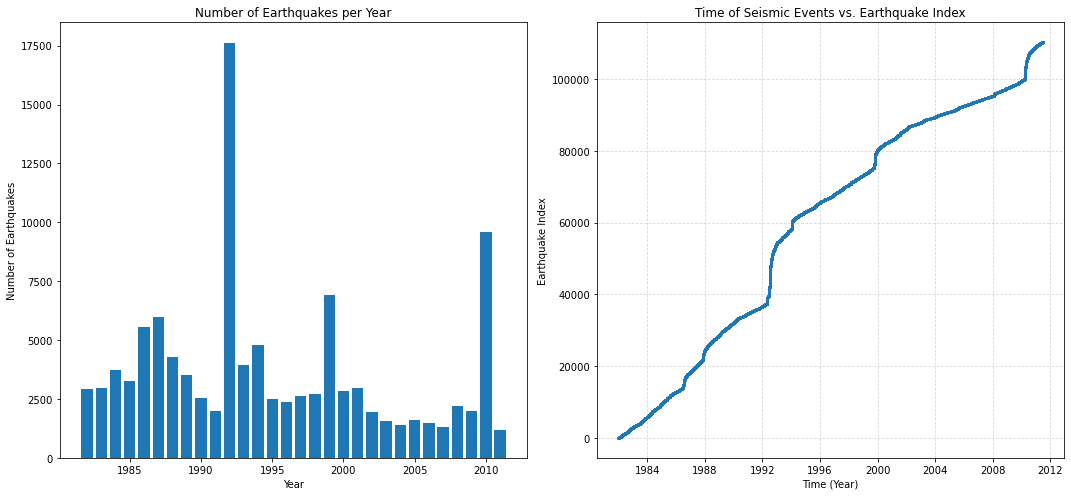

In [79]:
# Converts seconds to dates
start_date = datetime(1982, 1, 1)
datat = df['Time'].apply(lambda x: start_date + timedelta(seconds=x))


df["Year"] = datat.dt.year
count_earthquakes = df.groupby('Year')['Year'].count()
count_earthquakes.index

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

# Plot 1
ax1.bar(x=count_earthquakes.index, height=count_earthquakes)
ax1.set_xlabel('Year')
ax1.set_ylabel('Number of Earthquakes')
ax1.set_title('Number of Earthquakes per Year')

# Plot 2
ax2.plot_date(datat, df['Index'], markersize=1, alpha=1)
ax2.set_xlabel('Time (Year)')
ax2.set_ylabel('Earthquake Index')
ax2.set_title('Time of Seismic Events vs. Earthquake Index')
ax2.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


The first graph shows the number of earthquakes recorded each year from 1982-2011. It can be seen that the frequency of earthquake events is not constant over time. Some years have a significantly higher number of earthquakes than others.

The second graph shows the earthquake index as a function of time. Each point represents an earthquake, with the earthquake index on the y-axis and time on the x-axis. This graph allows you to visualize how earthquake events are distributed over time. It can be notice that many earthquakes are concentrated in short intervals of time.

## 1.2 Magnitude Distribution

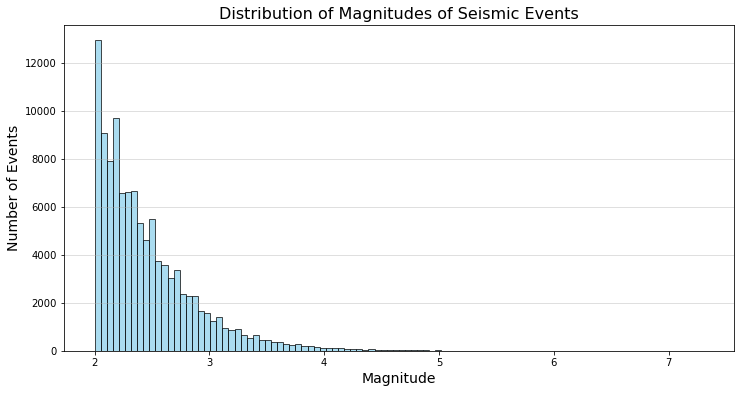

In [80]:
plt.figure(figsize=(12, 6))
plt.hist(df['Magnitude'], bins=100, edgecolor='k', color='skyblue', alpha=0.7)
plt.title('Distribution of Magnitudes of Seismic Events', fontsize=16)
plt.xlabel('Magnitude', fontsize=14)
plt.ylabel('Number of Events', fontsize=14)
plt.grid(axis='y', alpha=0.5)
plt.show()

The graph is a histogram showing the magnitude distribution of earthquake events. Most of the events have a magnitude around 2.5, with few events of magnitude greater than 4. This is typical of the distribution of seismic events, where high-magnitude events are much less frequent than low-magnitude events.

As can be seen from the previous graph, the frequency of earthquakes decreases exponentially with increasing magnitude, as stated by the Gutenberg-Richter law. In seismic regions such as Southern California, low to moderate magnitude earthquakes are more common due to the continued release of tectonic stresses along fault lines. While these smaller earthquakes contribute to overall seismic activity and regional risk, subsequent analyzes often prioritize earthquakes larger than magnitude 3 due to their significant impact and relevance. This approach allows for a targeted assessment of seismic risk and facilitates targeted studies of larger magnitude events.

## 1.3 3D Spatial Distribution

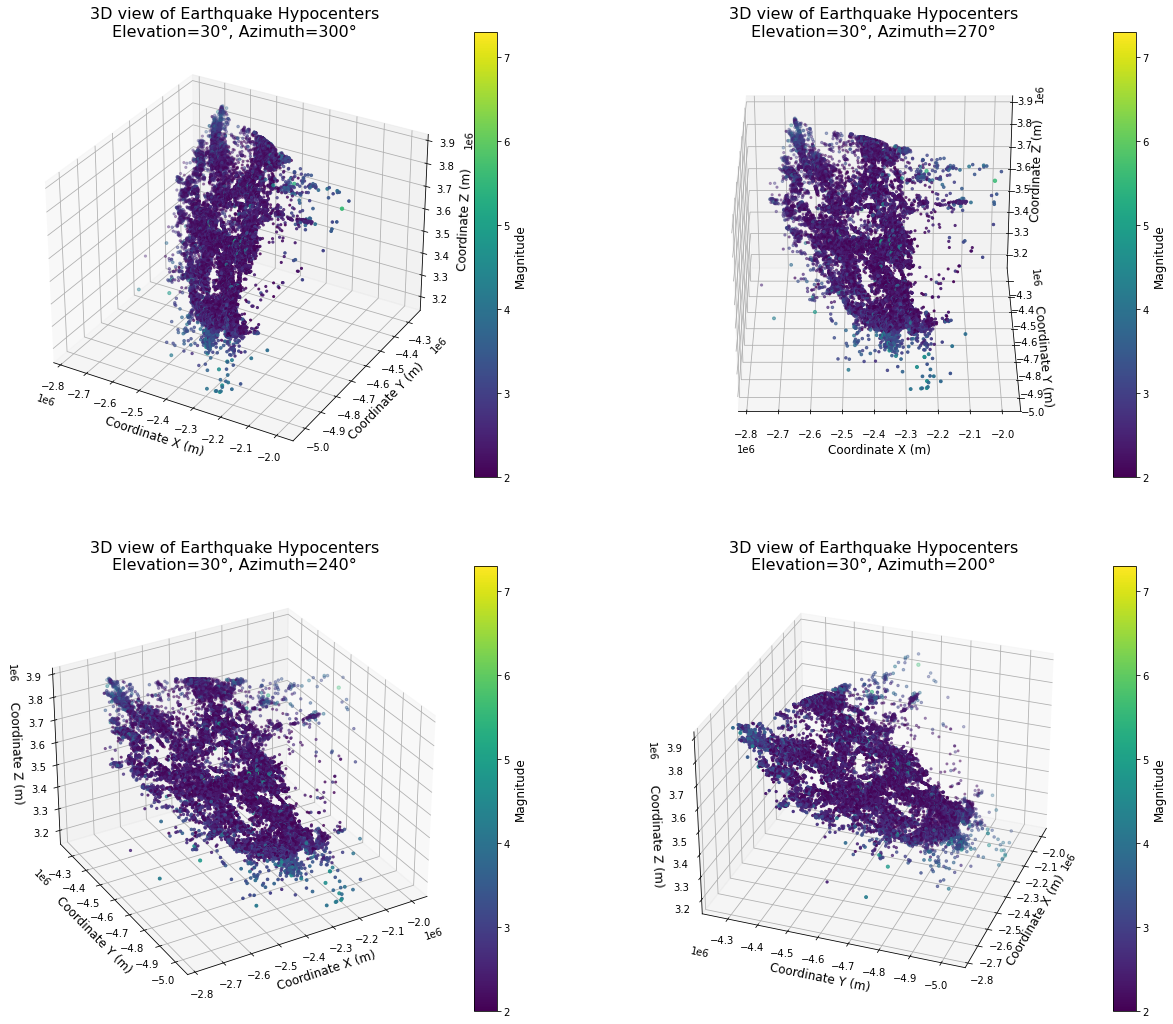

In [81]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

angles = [(30, 300), (30, 270), (30, 240), (30, 200)]

# Temporarily sort the dataset by magnitude intensity
df = df.sort_values(by=['Magnitude'])

fig = plt.figure(figsize=(21, 18))
for i, (elev, azim) in enumerate(angles):
    ax = fig.add_subplot(2, 2, i+1, projection='3d')
    sc = ax.scatter(df['x'], df['y'], df['z'], c=df['Magnitude'], cmap='viridis', s=df['Magnitude']*2)
    
    ax.view_init(elev, azim)

    plt.title(f'3D view of Earthquake Hypocenters\nElevation={elev}°, Azimuth={azim}°', fontsize=16)
    ax.set_xlabel('Coordinate X (m)', fontsize=12)
    ax.set_ylabel('Coordinate Y (m)', fontsize=12)
    ax.set_zlabel('Coordinate Z (m)', fontsize=12)
    cbar = plt.colorbar(sc, label='Magnitude')
    cbar.set_label('Magnitude', fontsize=12)
    
plt.show()

The data provide valuable insight into the spatial distribution and characteristics of earthquakes. The presence of clustered hypocenters suggests the
existence of active faults in specific areas. This observation is significant as it helps to identify regions with higher seismic activity and potentia
seismic risk.

The depth of the hypocenters along the Z axis provides crucial information on the location of seismic events within the earth's crust. Depth variations can
indicate different geological structures or fault systems involved in seismic activity. By analyzing this aspect, a better understanding of subsurface
dynamics and earthquake behavior in the region can be obtained.

Representation of magnitude through color allows for a visual understanding of earthquake intensity. By identifying the areas where high magnitude events
are clustered, it is possible to identify regions of particular seismic interest. These areas may require closer monitoring, improved building codes, and
effective disaster preparedness measures to mitigate the potential hazards associated with large earthquakes.

## 1.4 2D Representation of earthquakes on the map of southern california

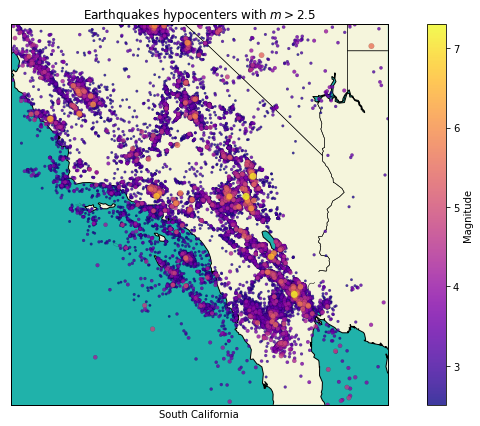

In [82]:
# Prep Figure
fig, ax = plt.subplots(figsize=(14,7))

# Transformation from Cartesian to spherical coordinates
R = 6371500  # Earth's radius

df["Longitude"] = np.degrees(np.arctan2(df["y"], df["x"]))
df["Latitude"] = np.degrees(np.arcsin(df["z"] / np.sqrt(df["x"] ** 2 + df["y"] ** 2 + df["z"] ** 2)))
df["Depth"] = np.sqrt(df["x"] ** 2 + df["y"] ** 2 + df["z"] ** 2) - R

# Temporarily sort the dataset by magnitude intensity
df = df.sort_values(by=['Magnitude'])

# Projection of the earthquake hypocenters onto a 2D plot over the map of California using the
# Mercator transform: method for projecting the Earth's curved surface onto a flat plane
map = Basemap(
    projection='merc',              # Mercator transform method
    resolution = 'i',               # Intermediate resolution
    llcrnrlon=min(df["Longitude"]), # min longitude
    llcrnrlat=min(df["Latitude"]),  # min latitude
    urcrnrlon=max(df["Longitude"]), # Max longitude
    urcrnrlat=max(df["Latitude"])   # Max latitude
)  

# Draw coastlines on the map
map.drawcoastlines() 

# Draw state boundaries on the map
map.drawstates()  

# Draw county boundaries on the map
map.drawcounties()  

# Fill continents and lakes
map.fillcontinents(color='beige', lake_color='lightseagreen')  

# Draw the boundary of the map and fill it
map.drawmapboundary(fill_color='lightseagreen') 

# Minimum magnitude represented
magn_m = 2.5


# Filters earthquake data based on a magnitude threshold (magn_m)
lon_tr = df['Longitude'][df['Magnitude']>magn_m]
lat_tr = df['Latitude'][df['Magnitude']>magn_m]
depth = df['Depth'][df['Magnitude']>magn_m]

# maps the filtered coordinates onto the map and assigning the projected coordinates to variables xm and ym
x_tr, y_tr = map(lon_tr, lat_tr)

# 2D plot
map_2d = map.scatter(x_tr, y_tr,
                        
# Set the size of the points based on the squared magnitude values from the 'magnitude' column of the DataFrame
s=df['Magnitude'][df['Magnitude']>magn_m]**2,

# Set the color of the points based on the magnitude values from the 'magnitude' column of the DataFrame
c=df["Magnitude"][df['Magnitude']>magn_m],

# Style
cmap='plasma', edgecolor='k', linewidth=0.1, alpha=0.8,

# Set the z-order of the points to 2 (controls the order of overlapping elements)
zorder=2)

ax.set_title('Earthquakes hypocenters with $m>{}$'.format(magn_m))  # title
ax.set_xlabel('South California')
m_cb = plt.colorbar(map_2d, ax=ax)  # colorbar
m_cb.set_label(label='Magnitude')   # colorbar

From this image it can be seen how the data are distributed in the southern california map. This may be useful for future considerations in the project.

# 2. Distribution $𝑃_𝑚(𝑡)$ of waiting times

## 2.a Computation of waiting times

In this section, we want to analyze the distribution of waiting time $t_w$, i.e. the time that takes between one event and the following. In particular, given a magnitude $m$, we want to look at earthquakes that have a magnitude above this threshold. We will perform this analysis for different values of $m = 2, 3, 4, 5$.

In [83]:
# Load dataset
df = load_dataset()

print("Original Dataset:\n\n",df[:5])

Original Dataset:

    Index  Trigger_index         Time  Magnitude        x        y        z
0      0             -1      0.00000       2.71 -2571956 -4627162  3520602
1      1              0  36501.39072       2.12 -2363740 -4787011  3461373
2      2              0  37488.27744       2.33 -2363746 -4786942  3461232
3      3              0  47982.51648       2.57 -2475085 -4664024  3548479
4      4              0  60268.57056       2.98 -2238642 -4839098  3469546


In [84]:
# First Magnitude selected = 3
m = 3

df_filtered = copy.deepcopy(df[df['Magnitude'] >= m])

print("Filtered Dataset:\n\n", df_filtered[:3])

print("\n\nThe number of earthquakes with a magnitude m >= 3 is: ", df_filtered.shape[0])

Filtered Dataset:

      Index  Trigger_index          Time  Magnitude        x        y        z
50      50              0  8.945939e+05       3.09 -2681989 -4474096  3623385
83      83              0  1.367108e+06       3.03 -2652587 -4419799  3714878
102    102              0  1.593043e+06       3.03 -2600530 -4569857  3582034


The number of earthquakes with a magnitude m >= 3 is:  11923


In [85]:
# New dataframe with Waiting Times and related earthquakes
df_waiting_times = pd.DataFrame()

# add Waiting Times column
df_waiting_times['WaitingTimes'] = np.zeros(df_filtered.shape[0])
df_waiting_times['WaitingTimes'][1:] = np.diff(df_filtered['Time']) # fill the new column with Waiting Times

# Add index1 column
df_waiting_times['Index1'] = np.zeros(df_filtered.shape[0])
df_waiting_times['Index1'][1:] = df_filtered['Index'][:-1].reset_index(drop=True)
df_waiting_times['Index1'] = df_waiting_times['Index1'].astype(int)

# Add index2 column
df_waiting_times['Index2'] = np.zeros(df_filtered.shape[0])
df_waiting_times.loc[1:, 'Index2'] = df_filtered['Index'].reset_index(drop=True)

 # get rid of NaN
df_waiting_times = df_waiting_times.dropna()

print("Waiting time associated with earthquakes index:")
df_waiting_times

Waiting time associated with earthquakes index:


,WaitingTimes,Index1,Index2
0,0.00000,0,0.0
1,472514.40288,50,83.0
2,225934.51392,83,102.0
3,220557.18528,102,113.0
4,103178.48256,113,121.0
...,...,...,...
11918,288346.25376,110235,110245.0
11919,51619.03200,110245,110248.0
11920,25887.41856,110248,110249.0
11921,80589.07296,110249,110252.0


## 2.b Linear binning

We want to plot the waiting times distribution with grater or equal to a certain magnitude $m$. In order to to this, we have to choose a proper binning size and to normalize the counts in the y axis so that we obtain a probability distribution function.
In this first part, we just plot the $n=11923$ Waiting Times VS the Occurrences.
The choice of the number of bins in a histogram can significantly affect the appearance of the graph and, consequently, the conclusions that can be drawn from the data. Too many bins can lead to an overly fragmented and noisy graph, while too few bins may not reveal the underlying structures in the data.

In statistics, a common rule is to use a number of bins proportional to $\sqrt n$ where $n$ is the number of data points. This rule works well for many data sets. To test whether the square root rule is appropriate for our data, it might be useful to create histograms with a lower and higher number of bins and compare the results. Our goal is to choose a number of bins that reveals the underlying structure of the data without introducing too much noise.

We then proceed to create three histograms for the data set with magnitude ≥ 3: one with a number of bins proportional to $0.5 \sqrt n$, one with $\sqrt n$ and one with $2 \sqrt n$

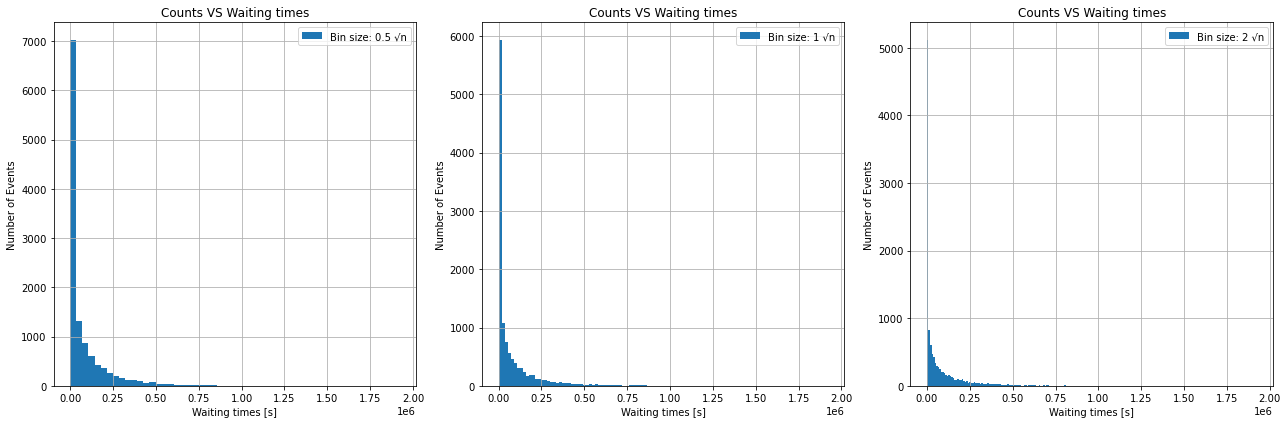

In [86]:
def plot_waiting_times(df_waiting_times, bin_size_multiplier, subplot_index):

    plt.subplot(1, 3, subplot_index)
    plt.hist(df_waiting_times['WaitingTimes'], bins=int(bin_size_multiplier * np.sqrt(df_waiting_times.shape[0])), density=False)
    plt.title(f'Counts VS Waiting times')
    plt.ylabel('Number of Events')
    plt.xlabel('Waiting times [s]')
    plt.grid()
    plt.legend([f'Bin size: {bin_size_multiplier} \u221An'])

# Create a new figure with subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plot for different bin sizes
for i, bin_size_multiplier in enumerate([0.5, 1, 2]):
    plot_waiting_times(df_waiting_times, bin_size_multiplier, i+1)

# Adjust spacing between subplots
plt.tight_layout()

# Display the figure
plt.show()

In this case, the choice of $\sqrt n$ seems to be a good compromise between capturing the underlying structure of the data and limiting noise.

As we can see from the plot, we have a power-law decay with time.

Now we have just plotted the Counts VS the Waiting Times. Since we are interested in computing the probability distribution $P_m(t)$ of waiting times for events of magnitude $m$ or above, we want the  the area of the histogram to be equal to 1. In order to normalize the histogram, we take advantage of the tools provided by Seaborn library.
We plotted our the probability distribution in linear scale in order to show its power-law behaviour.

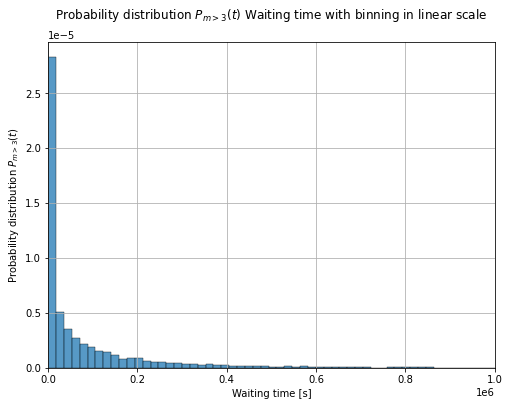

In [87]:
# Normalize the histogram setting stat = 'density' in order to have the area of the histogram equal to 1
fig, ax = plt.subplots(figsize=(8, 6))
ax = sns.histplot(df_waiting_times['WaitingTimes'], bins=int(np.sqrt(df_waiting_times.shape[0])), stat='density')
ax.set_title('Probability distribution $P_{m>3}(t)$ Waiting time with binning in linear scale\n')
ax.set_xlabel('Waiting time [s]')
ax.set_ylabel('Probability distribution $P_{m>3}(t)$')
ax.set_xlim(0,1*10**6)
plt.grid()
plt.show()

## 2.c Logarithmic binning

From the theory, we know that a power-law function produces a linear relationship when logarithms are taken of both $x$ and $y$ axis.

Therefore, in order to have a better visualization of the power-law, we decide to plot the probability distribution function in the log-log scale. As a result, we will have a straight-line on the log–log plot, that is called the signature of a power law.

In order to have a proper representation of the data, we need to distribute information uniformly in the bins taking into account that we are representing them in log scale. Therefore, we will create a logarithmic space for the x axis in order to have equally spaced bins in the log scale.

Now we decide to plot the histogram with dots in order to have a better understanding of the function trend.

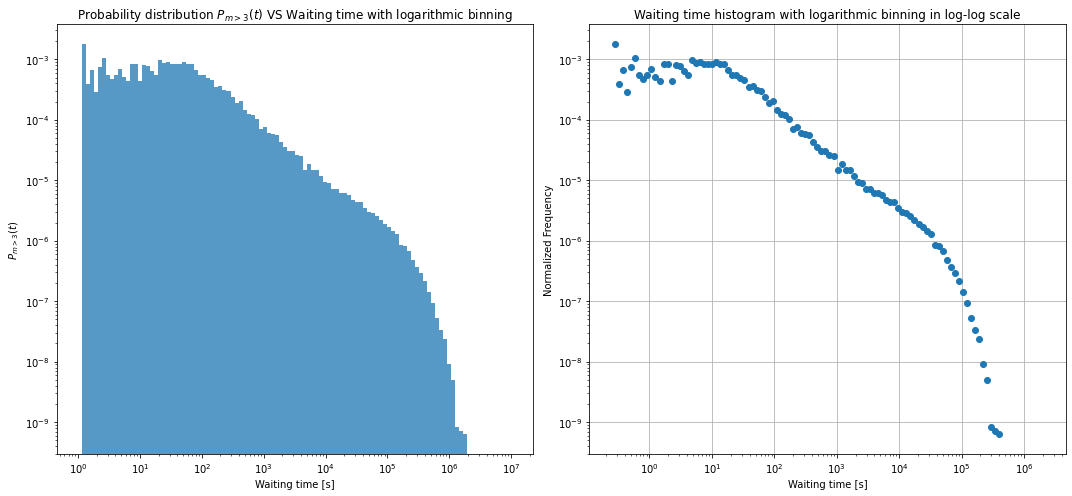

In [88]:
# Bins in log scale

# Size of the bins
binning_size = int(np.sqrt(df_waiting_times.shape[0])) 

# Width of the bins
bins_width = np.logspace(0, 7, binning_size)

# Histogram with logarithmic binning
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

# Plot 1 (Plot a normalized histogram)
ax1 = sns.histplot(df_waiting_times['WaitingTimes'], bins=bins_width, stat = 'density', ax = ax1)
ax1.set_title('Probability distribution $P_{m>3}(t)$ VS Waiting time with logarithmic binning')
ax1.set_xlabel('Waiting time [s]')
ax1.set_ylabel('$P_{m>3}(t)$')
ax1.set_yscale('log')
ax1.set_xscale('log')

bins_width = np.array([h.get_width() for h in ax1.patches]) 

# Calculate the center of the bins
waiting_time_log = np.add(bins_width,bins_width/2.)
norm_freq_log = [h.get_height() for h in ax1.patches]

ax2.plot(waiting_time_log, norm_freq_log, 'o')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_title('Waiting time histogram with logarithmic binning in log-log scale')
ax2.set_xlabel('Waiting time [s]')
ax2.set_ylabel('Normalized Frequency')
ax2.grid()

plt.tight_layout() # Add spacing between plots
plt.show()

## 2.d Power-law - fit the function

The power law distribution has the following formula:

$P(x) = Cx^{-k}$ where $x$ is the vector that contains the Waiting Times.

In a log-log plot it becomes:
$\log_{10} P(x) = \log_{10}(C) - k \log_{10} x$
that is a a straight line.
Now we would like to fit a linear function to the data represented in log-log scale, thus we need to find the intercept and the slope applying linear regression.

However, as we can see from the figure, the power-law behaviour covers only a portion of data. In order to fit linear function, we need to design a strategy to select only the points that follow the power-law regime. Therefore we need to fix a lower and a upper bound for the Waiting Times that we will consider for the fitting.

First, let's go through an analysis of earthquakes with a very low waiting time, which are represented with a flat distribution. We decide to consider only Waiting Times above a certain value fixed to $10^{1.5} = 31.62 $, that will be our lower bound.

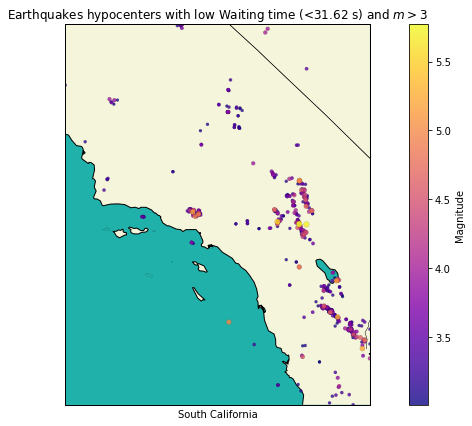

In [89]:
# Filter the data by considering the earthquakes having very low waiting times, represented by a flat distribution
df_flat_distribution = df_waiting_times[df_waiting_times['WaitingTimes'] < 10**(1.5)]

# Obtain a vector with all the earthquakes satisfied by the constraint
vector = np.concatenate([df_flat_distribution['Index1'].values, df_flat_distribution['Index2'].values])
vector = np.unique(vector)
vector = vector[1:]

# Prep Figure
fig, ax = plt.subplots(figsize=(14,7))

R = 6371500  # Earth's radius

# Transformation from Cartesian to spherical coordinates
df["Longitude"] = np.degrees(np.arctan2(df["y"], df["x"]))
df["Latitude"] = np.degrees(np.arcsin(df["z"] / np.sqrt(df["x"] ** 2 + df["y"] ** 2 + df["z"] ** 2)))
df["Depth"] = np.sqrt(df["x"] ** 2 + df["y"] ** 2 + df["z"] ** 2) - R

# Temporarily sort the dataset by magnitude intensity
df = df.sort_values(by=['Magnitude'])

# Filter original dataset with earthquakes having waiter time with flat distribution
df_filtered_waiting_time = df[df['Index'].isin(vector)]

# Projection of the earthquake hypocenters onto a 2D plot over the map of California using the
# Mercator transform: method for projecting the Earth's curved surface onto a flat plane
map = Basemap(
    projection='merc',              # Mercator transform method
    resolution = 'i',               # Intermediate resolution
    llcrnrlon=min(df_filtered_waiting_time["Longitude"]), # min longitude
    llcrnrlat=min(df_filtered_waiting_time["Latitude"]),  # min latitude
    urcrnrlon=max(df_filtered_waiting_time["Longitude"]), # Max longitude
    urcrnrlat=max(df_filtered_waiting_time["Latitude"])   # Max latitude
)  

# Draw coastlines on the map
map.drawcoastlines() 

# Draw state boundaries on the map
map.drawstates()  

# Draw county boundaries on the map
map.drawcounties()  

# Fill continents and lakes
map.fillcontinents(color='beige', lake_color='lightseagreen')  

# Draw the boundary of the map and fill it
map.drawmapboundary(fill_color='lightseagreen') 

# Minimum magnitude represented
magn_m = 3

# Filters earthquake data based on a magnitude threshold (magn_m)
lon_tr = df_filtered_waiting_time['Longitude'][df_filtered_waiting_time['Magnitude']>magn_m]
lat_tr = df_filtered_waiting_time['Latitude'][df_filtered_waiting_time['Magnitude']>magn_m]
depth = df_filtered_waiting_time['Depth'][df_filtered_waiting_time['Magnitude']>magn_m]

# maps the filtered coordinates onto the map and assigning the projected coordinates to variables xm and ym
x_tr, y_tr = map(lon_tr, lat_tr)

# 2D plot
map_2d = map.scatter(x_tr, y_tr,
                        
# Set the size of the points based on the squared magnitude values from the 'magnitude' column of the DataFrame
s=df_filtered_waiting_time['Magnitude'][df_filtered_waiting_time['Magnitude']>magn_m]**2,

# Set the color of the points based on the magnitude values from the 'magnitude' column of the DataFrame
c=df_filtered_waiting_time["Magnitude"][df_filtered_waiting_time['Magnitude']>magn_m],

# Style
cmap='plasma', edgecolor='k', linewidth=0.1, alpha=0.8,

# Set the z-order of the points to 2 (controls the order of overlapping elements)
zorder=2)

ax.set_title('Earthquakes hypocenters with low Waiting time (<31.62 s) and $m>{}$'.format(magn_m))  # title
ax.set_xlabel('South California')
m_cb = plt.colorbar(map_2d, ax=ax)  # colorbar
m_cb.set_label(label='Magnitude')   # colorbar

When the waiting times between seismic events are very short, it might be difficult to distinguish separate events, especially if their magnitude is similar. In our case, the earthquakes considered are in areas very close to each other. This could lead to overlapping or recording errors, which could distort the distribution of waiting times. Therefore, it was decided to exclude these points from the fit to obtain a more accurate representation of the long-term behavior of the waiting time distribution.

In [90]:
# logarithmic binning
bins_width = np.logspace(1.5, 7, int(np.sqrt(df_filtered.shape[0])))
x_bins = np.cumsum(bins_width)

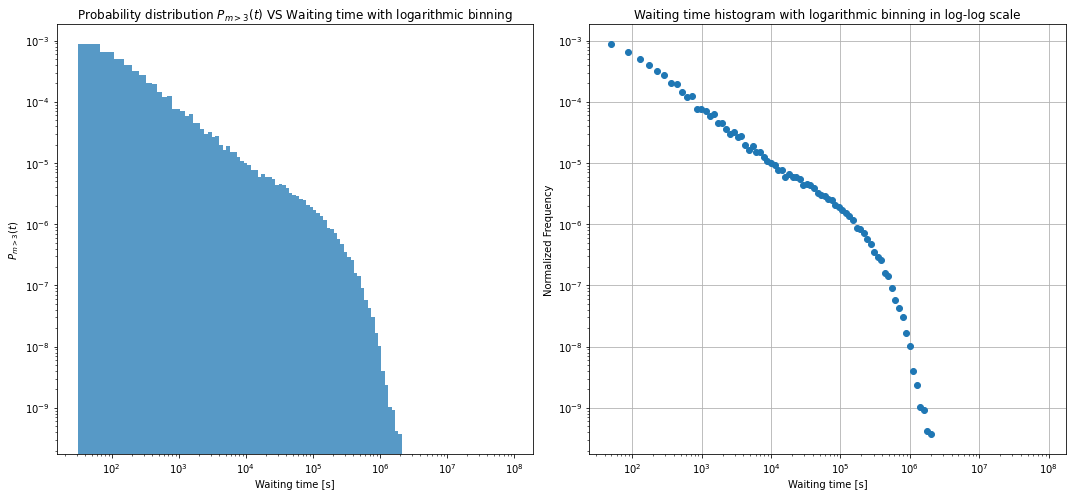

In [91]:
# Histogram with logarithmic binning
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))  # Create subplots

# Plot 1
ax1 = sns.histplot(df_waiting_times['WaitingTimes'][0:], bins=x_bins, stat = 'density', ax = ax1) # plot a normalized histogram
ax1.set_title('Probability distribution $P_{m>3}(t)$ VS Waiting time with logarithmic binning')
ax1.set_xlabel('Waiting time [s]')
ax1.set_ylabel('$P_{m>3}(t)$')
ax1.set_yscale('log')
ax1.set_xscale('log')

bins_width = np.array([h.get_width() for h in ax1.patches]) 
x_bins = np.array([h.get_xy()[0] for h in ax1.patches])

# Calculate the center of the bins
waiting_time_log = np.add(x_bins,bins_width/2.)
norm_freq_log = [h.get_height() for h in ax1.patches]

ax2.plot(waiting_time_log, norm_freq_log, 'o')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_title('Waiting time histogram with logarithmic binning in log-log scale')
ax2.set_xlabel('Waiting time [s]')
ax2.set_ylabel('Normalized Frequency')
ax2.grid()

plt.tight_layout() # Add spacing between plots
plt.show()

In [21]:
# create DataFrame to associate WaitingTimes and Normalized Frequencies
time_freq = pd.DataFrame({'WaitingTimes':waiting_time_log, 'NormalizedFrequency':norm_freq_log})

# since we want to compute the logarithm, we need to exclude values with NormalizedFrequency equal to 0
time_freq = time_freq[time_freq['NormalizedFrequency'] > 0]

# compute the logarithm
wait_time = np.log10(np.array(time_freq['WaitingTimes'])).reshape(-1,1)
norm_freq = np.log10(np.array(time_freq['NormalizedFrequency'])).reshape(-1,1)

In order to analyze waiting times in earthquakes, we utilize an algorithm that focuses on the head of the distribution. This algorithm excludes the highest waiting times by computing the Mean Squared Error (MSE) loss. By observing the distribution, we can identify a bend on the right side, indicating a power law decay for waiting times up to $10^5$, while waiting times greater than $10^6$ exhibit a faster decay. To perform linear regression, we must omit the highest waiting times and set an upper bound. Consequently, we employ an algorithm on the right side that selects the last point before the bend, determined by calculating the MSE loss between the actual and expected values.

The occurrence of earthquakes with lengthy waiting times is less probable. This can be explained by the fact that earthquakes happening at significant distances from each other are less likely to be correlated. Instead, they are generated by independent, random processes.

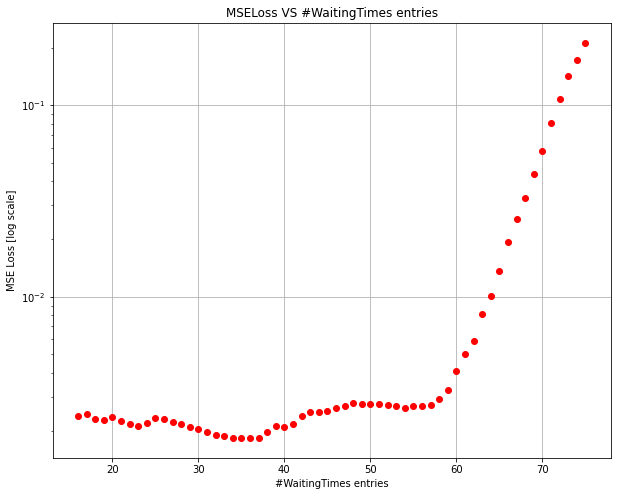

In [22]:
MSE_loss_vec = []
MSE_loss_index = []

wait_time = wait_time.reshape(-1, 1)
norm_freq = norm_freq.reshape(-1, 1)

start = int(len(wait_time)*2/9)

for n in range(start, len(wait_time)):
    wait_time_red = wait_time[:n]
    norm_freq_red = norm_freq[:n]
    model = LinearRegression().fit(wait_time_red, norm_freq_red)
    norm_freq_predict = model.predict(wait_time_red)
    MSE_loss = np.square(np.subtract(norm_freq_red, norm_freq_predict)).mean()
    MSE_loss_vec.append(MSE_loss)
    MSE_loss_index.append(n)

fig = plt.subplots(figsize=(10,8))
plt.plot(MSE_loss_index, MSE_loss_vec,'or')
plt.title('MSELoss VS #WaitingTimes entries')
plt.xlabel('#WaitingTimes entries')
plt.ylabel('MSE Loss [log scale]')
plt.yscale('log')
plt.grid()
plt.show()

In [23]:
# Filter data considering the minimim MSE

index_vs_MSE = list(zip(MSE_loss_index, MSE_loss_vec))

df_MSE = pd.DataFrame(index_vs_MSE,columns=['MSEindex','MSEloss'])

# Choose the last point of the set as lower bound
MSE_min =  np.array(df_MSE.loc[df_MSE['MSEloss'] == df_MSE['MSEloss'].min()])
MSE_min_index = int(MSE_min[0, 0])
MSE_min_value = (MSE_min[0, 1])
print("Minimim MSE:\nIndex: ",MSE_min_index)
print("Value: ",MSE_min_value)

Minimim MSE:
Index:  35
Value:  0.0018287031385663041


In [24]:
v = time_freq.loc[MSE_min_index, 'WaitingTimes']
order = int(np.floor(np.log10(v)))

# logarithmic binning
bins_width = np.logspace(1.5, order, int(np.sqrt(df_filtered.shape[0])))
x_bins = np.cumsum(bins_width) 

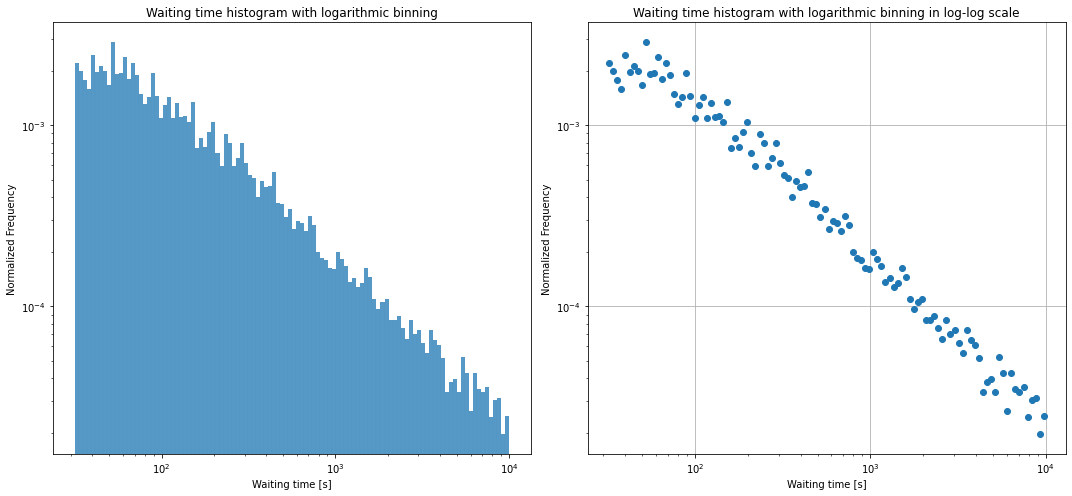

In [25]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))  # Create subplots

ax1 = sns.histplot(df_waiting_times['WaitingTimes'], bins=bins_width, kde=False, stat= 'density', ax = ax1) # Plot a normalized histogram

ax1.set_title('Waiting time histogram with logarithmic binning')
ax1.set_xlabel('Waiting time [s]')
ax1.set_ylabel('Normalized Frequency')
ax1.set_xscale('log')
ax1.set_yscale('log')

bins_width = np.array([h.get_width() for h in ax1.patches]) 
x_bins = np.array([h.get_xy()[0] for h in ax1.patches])

# Calculate the center of the bins
waiting_time_log = np.add(x_bins,bins_width/2.)
norm_freq_log = [h.get_height() for h in ax1.patches]

ax2.plot(waiting_time_log, norm_freq_log, 'o')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_title('Waiting time histogram with logarithmic binning in log-log scale')
ax2.set_xlabel('Waiting time [s]')
ax2.set_ylabel('Normalized Frequency')
ax2.grid()

plt.tight_layout()  # Add spacing between plots
plt.show()

In [26]:
# create DataFrame to associate WaitingTimes and Normalized Frequencies
time_freq = pd.DataFrame({'WaitingTimes':waiting_time_log, 'NormalizedFrequency':norm_freq_log})

# since we want to compute the logarithm, we need to exclude values with NormalizedFrequency equal to 0
time_freq = time_freq[time_freq['NormalizedFrequency'] > 0]

# compute the logarithm
wait_time = np.log10(np.array(time_freq['WaitingTimes'])).reshape(-1,1)
norm_freq = np.log10(np.array(time_freq['NormalizedFrequency'])).reshape(-1,1)

wait_time = wait_time.flatten()
norm_freq = norm_freq.flatten()

Fit parameters:: -1.19 ± 0.03 -0.85 ± 0.01


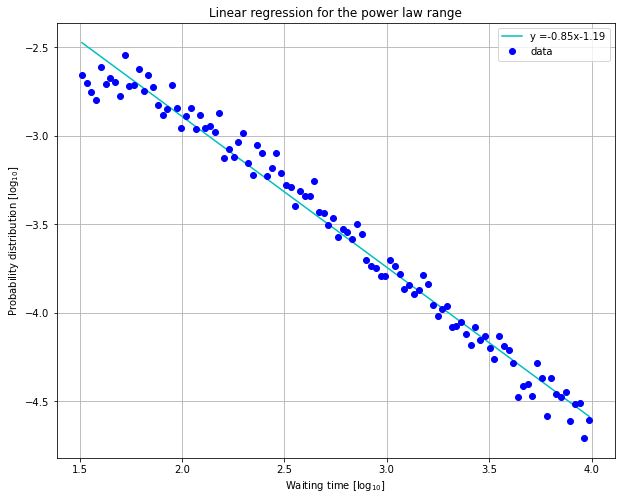

In [27]:
model, cov = np.polyfit(wait_time, norm_freq, deg=1, cov=True)

# Print Parameters of the Fit
print('Fit parameters:: %.2f \u00B1 %.2f'% (model[1], np.sqrt(cov[1][1])) , '%.2f \u00B1 %.2f'%(model[0], np.sqrt(cov[0][0])) )

# Plot fit
fig, ax = plt.subplots(figsize=(10,8))

ax.errorbar(wait_time, norm_freq, fmt='o', color='b', label='Data')
ax.plot(wait_time, model[1] + model[0]*wait_time, '-c', label= str(round(model[0], 2)) + "*t " + str(round(model[1], 2)) + " with m = " + str(m))

ax.set_title('Linear regression for the power law range')
ax.set_xlabel('Waiting time [log$_{10}$]')
ax.set_ylabel('Probability distribution [log$_{10}$]')

plt.legend(('y ={0:01.2f}x{1:01.2f}'.format(model[0],model[1]),'data'))
plt.grid()
plt.show()

As we expected, we have seen that the distribution have a power-law decay with time and we plotted it in log-log scale to visualize it in a proper way.

## Analysis for m = 2,3,4,5

In [28]:
def MSE_loss_func(wait_time, norm_freq):

    MSE_loss_vec = []
    MSE_loss_index = []

    wait_time = wait_time.reshape(-1, 1)
    norm_freq = norm_freq.reshape(-1, 1)

    for n in range(int(len(wait_time)*3/4), len(wait_time)):
        wait_time_red = wait_time[:n]
        norm_freq_red = norm_freq[:n]
        model = LinearRegression().fit(wait_time_red, norm_freq_red)
        norm_freq_predict = model.predict(wait_time_red)
        MSE_loss = np.square(np.subtract(norm_freq_red, norm_freq_predict)).mean()
        MSE_loss_vec.append(MSE_loss)
        MSE_loss_index.append(n)

    return MSE_loss_vec, MSE_loss_index

In [29]:

def fit_linear(MSE_loss_vec, MSE_loss_index, wait_time_red, norm_freq_red):

    index_vs_MSE = list(zip(MSE_loss_index, MSE_loss_vec))

    df_MSE = pd.DataFrame(index_vs_MSE,columns=['MSEindex','MSEloss'])

    # Choose the last point of the set as lower bound
    MSE_min_index =  np.array(df_MSE.loc[df_MSE['MSEloss'] == df_MSE['MSEloss'].min()])
    print(MSE_min_index)

    # Perform linear regression with the value that has the minimum MSE_loss
    wait_time_final = np.array(wait_time_red[0:int(MSE_min_index[0, 0])]).reshape(-1)
    norm_freq_final = np.array(norm_freq_red[0:int(MSE_min_index[0, 0])]).reshape(-1)

    model, cov = np.polyfit(wait_time_final, norm_freq_final, deg=1, cov=True)

    return wait_time_final, norm_freq_final, model, cov


[[10.          0.01517446]]


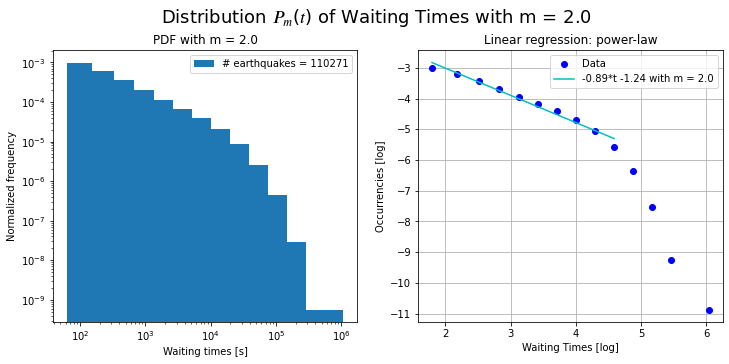

[[1.20000000e+01 1.55116463e-03]]


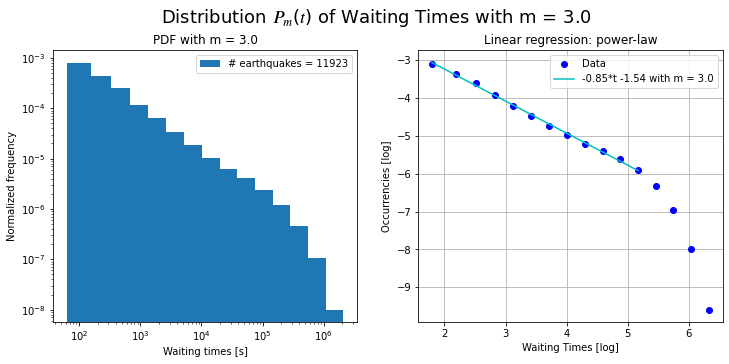

[[1.40000000e+01 3.02111488e-03]]


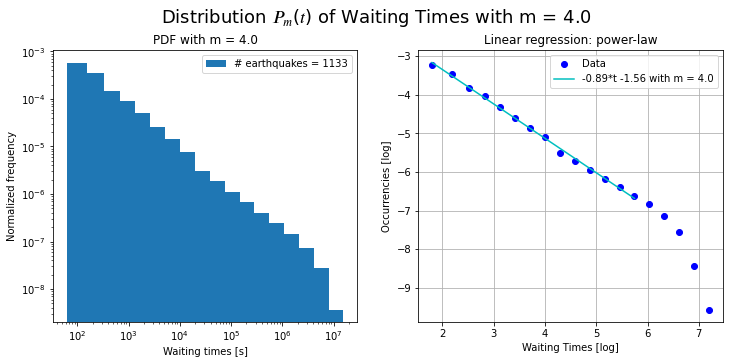

[[1.40000000e+01 1.38479238e-02]]


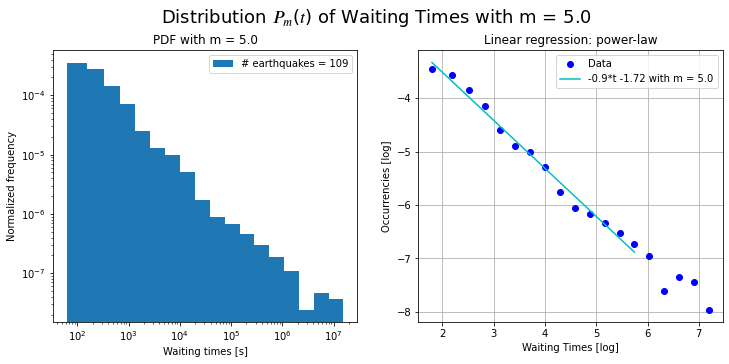

In [30]:
# Load dataset
df = load_dataset()

magnitude = np.linspace(2,5,4)

x_wait_time = []
y_norm_freq = []

x_wait_log = []
y_norm_log = []

# For each m
for i in range(len(magnitude)):

    # filter data with magnitude
    df_filtered_copy = copy.deepcopy(df[df['Magnitude'] >= magnitude[i]])
    df_filtered = pd.DataFrame()
    
    # Add column with Waiting Times
    df_filtered['WaitingTimes'] = np.zeros(df_filtered_copy.shape[0]) 
    df_filtered['WaitingTimes'][1:] = np.diff(df_filtered_copy['Time']) #  fill the new column with Waiting Times
    df_filtered = df_filtered.dropna()

    # Logspace for the x axis log-log plot
    x_width = np.logspace(1.5, 7, 20)
    x_edge = np.cumsum(x_width)
    
    # Compute x axis and y axis of the histogram
    fig, ax = plt.subplots(figsize=(10,8))
    ax = sns.histplot(df_filtered['WaitingTimes'], bins = x_edge, kde=False, stat='density')
    plt.close()

    edge = np.array([h.get_xy()[0] for h in ax.patches])
    width = np.array([h.get_width() for h in ax.patches])

    # Calculate the center of the bins
    x_wait_time_entry = np.add(edge,width/2.) 
    y_norm_freq_entry = [h.get_height() for h in ax.patches]

    time_freq = pd.DataFrame({'WaitingTimes': x_wait_time_entry, 'NormalizedFrequency': y_norm_freq_entry})

    # since we want to compute the logarithm, we need to exclude values with NormalizedFrequency equal to 0
    time_freq = time_freq[time_freq['NormalizedFrequency'] > 0]
    wait_time = np.log10(np.array(time_freq['WaitingTimes'])).reshape(-1,1)
    norm_freq = np.log10(np.array(time_freq['NormalizedFrequency'])).reshape(-1,1)

    # Calculate the center of the bins
    x_wait_time.append(np.array(time_freq['WaitingTimes']))
    y_norm_freq.append(np.array(time_freq['NormalizedFrequency']))

    # Figure
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2,figsize=(12, 5))

    # Plot 1
    ax1.stairs(y_norm_freq[i][:-1], x_wait_time[i], fill = True, label="# earthquakes = " + str(len(df_filtered['WaitingTimes'])))
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax1.set_xlabel('Waiting times [s]')
    ax1.set_ylabel('Normalized frequency')
    ax1.set_title('PDF with m = ' + str(magnitude[i]))
    ax1.legend()

    # Calculate the center of the bins
    x_wait_log.append(wait_time)
    y_norm_log.append(norm_freq)

    # MSE_loss
    MSE_loss_vec, MSE_loss_index = MSE_loss_func(x_wait_log[i], y_norm_log[i])

    # Fit the data
    wait_time_final, norm_freq_final, model, cov = fit_linear(MSE_loss_vec, MSE_loss_index, wait_time, norm_freq)

    # Plot 2
    ax2.plot(wait_time, norm_freq, 'ob', label = "Data")
    ax2.plot(wait_time_final, model[1] + model[0]*wait_time_final, '-c' , label= str(round(model[0], 2)) + "*t " + str(round(model[1], 2)) + " with m = " + str(magnitude[i]))

    ax2.legend()
    ax2.set_xlabel('Waiting Times [log]')
    ax2.set_ylabel('Occurrencies [log]')
    ax2.set_title("Linear regression: power-law")
    ax2.grid()
    
    fig.suptitle("Distribution $𝑃_𝑚(𝑡)$ of Waiting Times with m = " + str(magnitude[i]), x=0.5, y=1, fontsize=18)
    plt.show()

In order to rescale the plots and to see the curves collapsed, we have to normalize both x axis and y axis. For y axis, we took advantage of Searsborn library and we plotted the points so that 

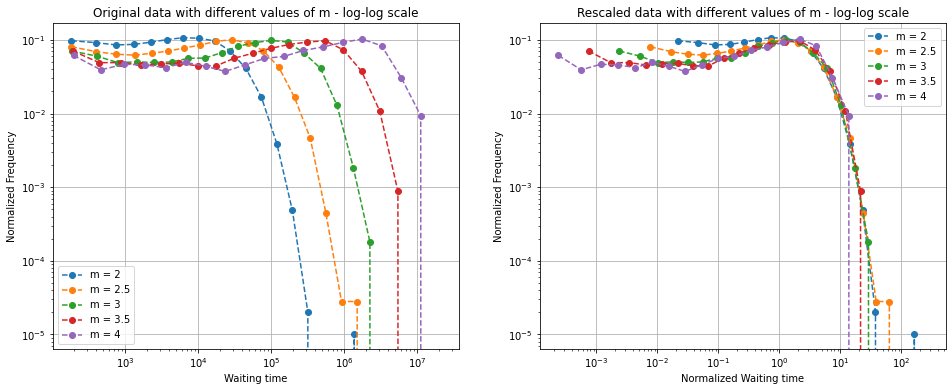

In [31]:
# Set the value of m
m_vec = [2, 2.5, 3, 3.5, 4]
number_of_bins = 20

fig, axs = plt.subplots(1, 2, figsize=(16,6))  # Creates a figure with two subplots

for i in range(2):  # Loop over the subplots
    x_time_vec = []
    y_prob_vec = []
    
    for m in m_vec:  # Repeat the analysis for m in mag
        df_m = pd.DataFrame()

        df_m_copy = copy.deepcopy(df[df['Magnitude'] >= m])

        # Add column of waiting time
        df_m['WaitingTimes'] = np.zeros(df_m_copy.shape[0])
        df_m['WaitingTimes'][1:] = np.diff(df_m_copy['Time'])  # Compute the waiting time
        df_m = df_m.dropna()

        start = np.log10(df_m[df_m['WaitingTimes'] >= 10 ** 2].min())
        stop = np.log10(df_m[df_m['WaitingTimes'] <= 10 ** 10].max())

        width = np.logspace(start, stop, number_of_bins)
        edge = np.cumsum(width)

        # Create a temporary subplot to get the edges and heights of the histogram
        temp_fig, temp_ax = plt.subplots(figsize=(10, 8))
        temp_ax = sns.histplot(df_m['WaitingTimes'], bins=edge, stat='probability')
        plt.close()

        edge = np.array([h.get_xy()[0] for h in temp_ax.patches])
        width = np.array([h.get_width() for h in temp_ax.patches])

        if i == 0:
            # Calculate the center of the bins
            x_time = (np.add(edge, width / 2.))
        else:  # Normalized waiting time for the second subplot
            # Calculate the center of the bins
            x_time = (np.add(edge, width / 2.)) / df_m['WaitingTimes'].mean()
        y_prob = np.array([h.get_height() for h in temp_ax.patches])

        axs[i].plot(x_time, y_prob, '--o', label="m = " + str(m))

        x_time_vec.append(x_time)
        y_prob_vec.append(y_prob)

    axs[i].set_xscale('log')
    axs[i].set_yscale('log')
    if i == 0:
        axs[i].set_title('Original data with different values of m - log-log scale')
        axs[i].set_xlabel('Waiting time')
    else:
        axs[i].set_title('Rescaled data with different values of m - log-log scale')
        axs[i].set_xlabel('Normalized Waiting time')
    
    axs[i].set_ylabel('Normalized Frequency')
    axs[i].legend()
    axs[i].grid()

plt.show()

# 3. Distribution $P_m(r)$ of the distance between an event and the next one

For Point 3, we computed the distribution of the distance between successive events for earthquakes of magnitude $m$ or higher. We chose $m = [2,3,4,5]$ as a range of magnitude thresholds to examine the effects on the probability distribution at different magnitudes. Our selection of $r = [5, 10, 50, 250] km$ as possible distance thresholds was based on the maximum observed distance between events, which was approximately within the geographical dimensions of California (that are respectively 1220 km and 400 km).

In a linear scale, the distribution showed a hyperbolic trend, which led us to plot the data in a log-log scale for clearer representation. This yielded a linear function suggesting a power law relationship. We performed a fit to this data to obtain the parameters of the power law, excluding very low values with flat behavior to minimize noise. A point selection algorithm based on MSE (Mean Square Error) was used to choose appropriate points for the fit. This approach allowed us to consider only the portion of the distribution before it bent significantly, thereby obtaining a more accurate fit.



The number of earthquakes with a magnitude m >= 2 is:  110271

When m >= 2, the maximum distance is 953.3598368438854
                Time  x_distance_m_2  y_distance_m_2  z_distance_m_2  \
0       0.000000e+00             0.0             0.0             0.0   
1       3.650139e+04        208216.0       -159849.0        -59229.0   
2       3.748828e+04            -6.0            69.0          -141.0   
3       4.798252e+04       -111339.0        122918.0         87247.0   
4       6.026857e+04        236443.0       -175074.0        -78933.0   
...              ...             ...             ...             ...   
110266  9.304996e+08       -303164.0        443535.0        347410.0   
110267  9.305115e+08        371012.0       -488135.0       -365458.0   
110268  9.305318e+08       -107317.0        382623.0        422836.0   
110269  9.305363e+08         16422.0       -249944.0       -317218.0   
110270  9.305667e+08       -191078.0        281729.0        223133.0   

        xyz_dis

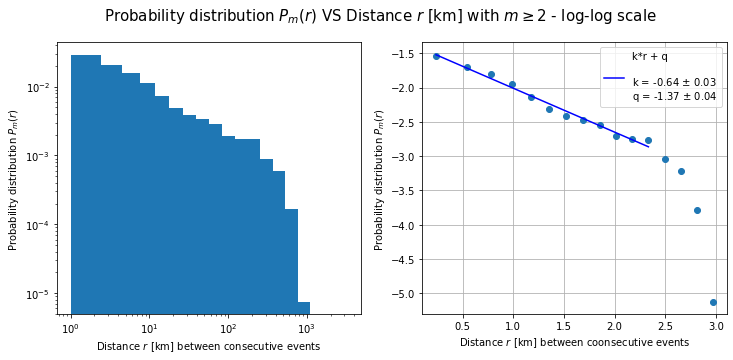

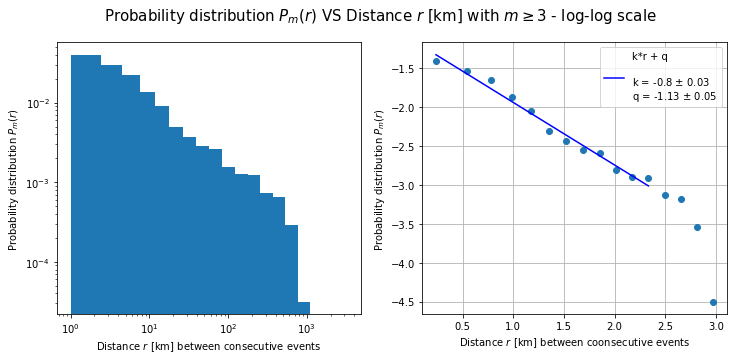

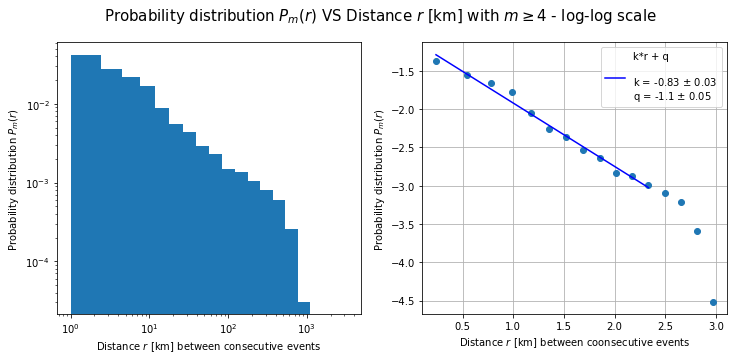

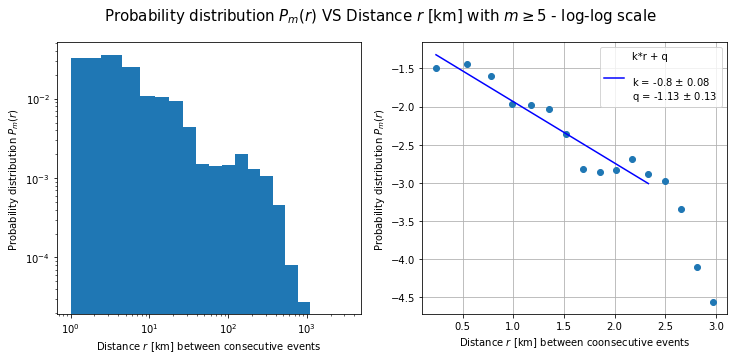

In [32]:
m_vec = np.array([2,3,4,5])

df_mR_vec = []

c = 0

ax_vec = []

for i in m_vec:

    # The dataframe is loaded and filtered according to the magnitude of the seismic event.
    # earthquakes with magnitude m or above
    df_filtered_copy = copy.deepcopy(df[df['Magnitude'] >= i])

    print("\n\nThe number of earthquakes with a magnitude m >= " + str(i) + " is: ", df_filtered_copy.shape[0])

    df_filtered_mR = pd.DataFrame()
    df_filtered_mR['Time'] = df_filtered_copy['Time']
    df_filtered_mR = df_filtered_mR.dropna() # get rid of NaN
    
    # initialize all the values to zero
    df_filtered_mR['x_distance_m_'+str(i)]= np.zeros(df_filtered_mR.shape[0])
    df_filtered_mR['y_distance_m_'+str(i)] = np.zeros(df_filtered_mR.shape[0])
    df_filtered_mR['z_distance_m_'+str(i)] = np.zeros(df_filtered_mR.shape[0])

    # compute the distance
    df_filtered_mR['x_distance_m_'+str(i)][1:] = np.diff(df_filtered_copy['x'])
    df_filtered_mR['y_distance_m_'+str(i)][1:] = np.diff(df_filtered_copy['y'])
    df_filtered_mR['z_distance_m_'+str(i)][1:] = np.diff(df_filtered_copy['z'])

    # Calculation of 3D Euclidean distance between consecutive events.
    xyz_distance = np.sqrt((df_filtered_mR['x_distance_m_'+str(i)])**2 +(df_filtered_mR['y_distance_m_'+str(i)])**2 +(df_filtered_mR['y_distance_m_'+str(i)])**2)/1000

    df_filtered_mR['xyz_distance_m_'+str(i)] = xyz_distance
    print("\nWhen m >= " + str(m_vec[c]) + ", the maximum distance is " + str(df_filtered_mR['xyz_distance_m_'+str(i)].max()))
    df_mR_vec.append(df_filtered_mR)

    print(df_filtered_mR)
    # maximum distance between consequent event
    R_max = df_filtered_mR['xyz_distance_m_'+str(i)].max()

    df_R = copy.deepcopy(df_mR_vec[c])

    width = np.logspace(0, 3, 20)
    edges = np.cumsum(width)

    # Figure
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2,figsize=(12, 5))
    fig.suptitle("Probability distribution $P_{m}(r)$ VS Distance $r$ [km] with $m\geq$" + str(i) + " - log-log scale", fontsize=15)

    ax = ax1.hist(df_R['xyz_distance_m_' + str(i)], bins = edges, density = True, label = "m >= " + str(m_vec[c]))
    ax_vec.append(ax)
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax1.set_xlabel('Distance $r$ [km] between consecutive events')
    ax1.set_ylabel('Probability distribution $P_{m}(r)$')

    bins_width = np.array([h.get_width() for h in ax[2]])
    x_bins = np.array([h.get_xy()[0] for h in ax[2]])

    # Calculate the center of the bins
    x_distance_log = np.add(x_bins, bins_width/2.)
    norm_freq_log = np.array([h.get_height() for h in ax[2]])

    norm_freq_log_mask = norm_freq_log > 0
    x_distance_log = x_distance_log[norm_freq_log_mask]
    norm_freq_log = norm_freq_log[norm_freq_log_mask]

    print(norm_freq_log)
    x_distance = np.log10(x_distance_log).reshape(-1,1)
    norm_freq = np.log10(norm_freq_log).reshape(-1,1)

    MSE_loss_vec, MSE_loss_index = MSE_loss_func(x_distance_log, norm_freq_log)

    
    x_distance_final, norm_freq_final, model, cov = fit_linear(MSE_loss_vec, MSE_loss_index, x_distance, norm_freq)

    label_ax2 = "k*r + q\n\nk = " + str(round(model[0],2)) + " $\pm$ " + str(round(np.sqrt(cov[0,0]), 2)) + "\nq = " + str(round(model[1], 2)) + " $\pm$ " + str(round(np.sqrt(cov[1,1]),2))
    
    ax2.plot(x_distance, norm_freq, 'o', )
    ax2.plot(x_distance_final, model[1] + model[0]*x_distance_final, '-b' , label= label_ax2)
    ax2.legend()
    ax2.set_xlabel('Distance $r$ [km] between coonsecutive events')
    ax2.set_ylabel('Probability distribution $P_{m}(r)$')
    ax2.grid()
    
    c += 1

We rescaled the distribution of distances between consequent events as follows. For what concerns the y axis, we plotted the probability distribution function: each bin is given by the counts divided by the total number of counts and the bin width, so that the area under the histogram integrates to 1.

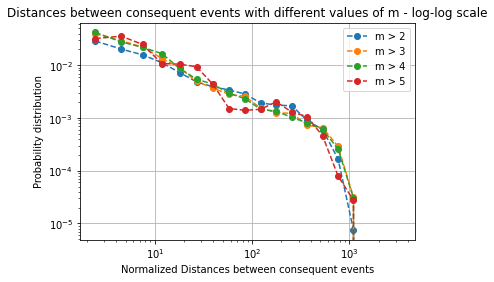

In [33]:
plt.figure()

for i in range(0, 4):
    plt.plot(ax_vec[i][1][1:], ax_vec[i][0], 'o--', label= "m > " + str(m_vec[i]))

plt.title("Distances between consequent events with different values of m - log-log scale")
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Normalized Distances between consequent events')
plt.ylabel('Probability distribution')
plt.legend()
plt.grid()

# 4. Distribution $P_{m, R}(t)$ of Waiting Times for events of magnitude m or above, separated by a distance $r < R$
Compute the distribution $P_{m,R}(t)$ of waiting times for events of magnitude $m$ or above, which are separated by at most a distance $r<R$, for different values of m and $R$. After a first filtering in which we selected earthquakes above a certain magnitude $m$, we implemented a for cycle in which we computed the distances w.r.t. the central entry and we kept only the entries within a fixed distance $r$. Then, we computed the Waiting Times between the central entry and all the selected entries that were located within a radius less than $r$ and eventually we plot the probability distribution $P_{m,R}(t)$. We choose a magnitude $m = [3.5, 4.0, 4.5]$ and $r = [5, 10, 50, 250] km$. 



The number of earthquakes with a magnitude m >= 3.0 is:  11923


Radius r < 5

The eathquake central entry w.r.t. which are computing the distance is: 1000 / 11923
With central entry 1000 and with r <= 5, the max distance is 3.44 km.

The eathquake central entry w.r.t. which are computing the distance is: 2000 / 11923
With central entry 2000 and with r <= 5, the max distance is 4.97 km.

The eathquake central entry w.r.t. which are computing the distance is: 3000 / 11923
With central entry 3000 and with r <= 5, the max distance is 4.32 km.

The eathquake central entry w.r.t. which are computing the distance is: 4000 / 11923
With central entry 4000 and with r <= 5, the max distance is 4.75 km.

The eathquake central entry w.r.t. which are computing the distance is: 5000 / 11923
With central entry 5000 and with r <= 5, the max distance is 4.95 km.

The eathquake central entry w.r.t. which are computing the distance is: 6000 / 11923
With central entry 6000 and with r <= 5, the max dista

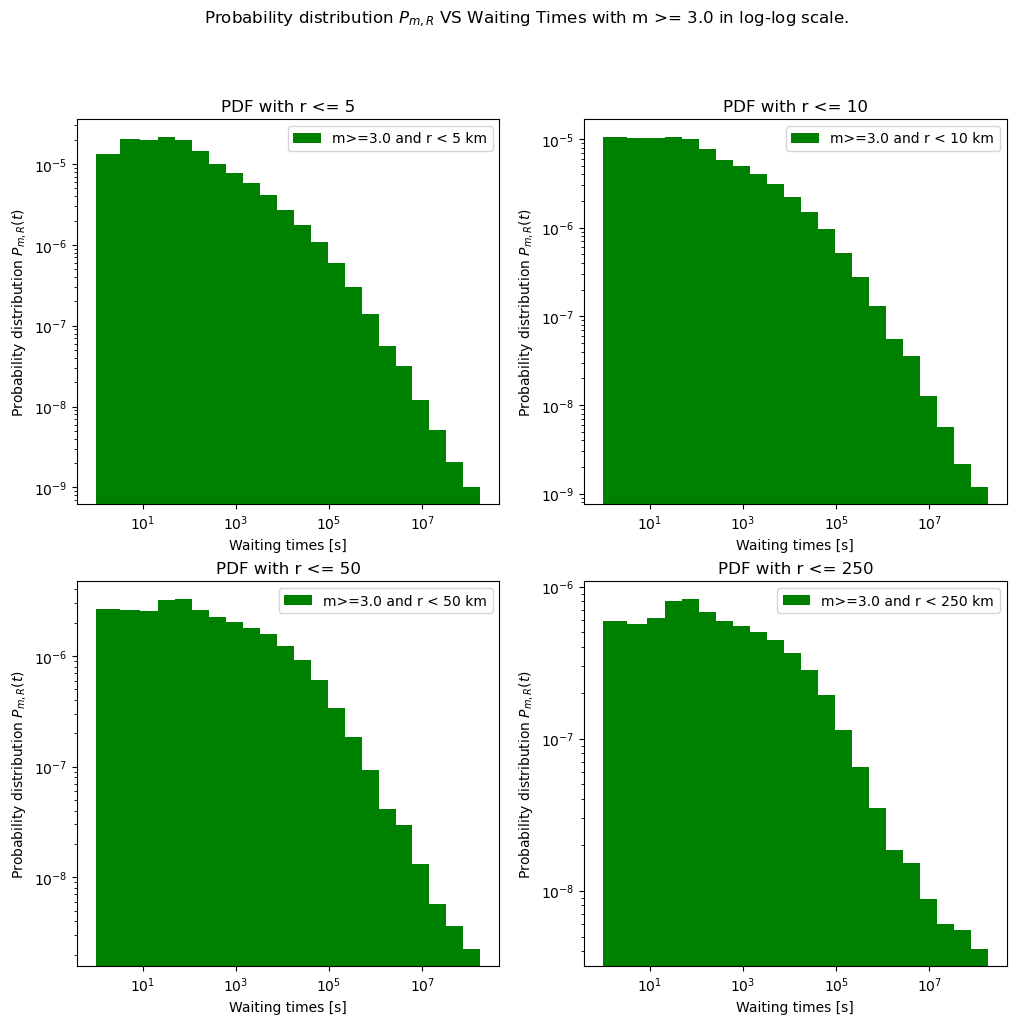

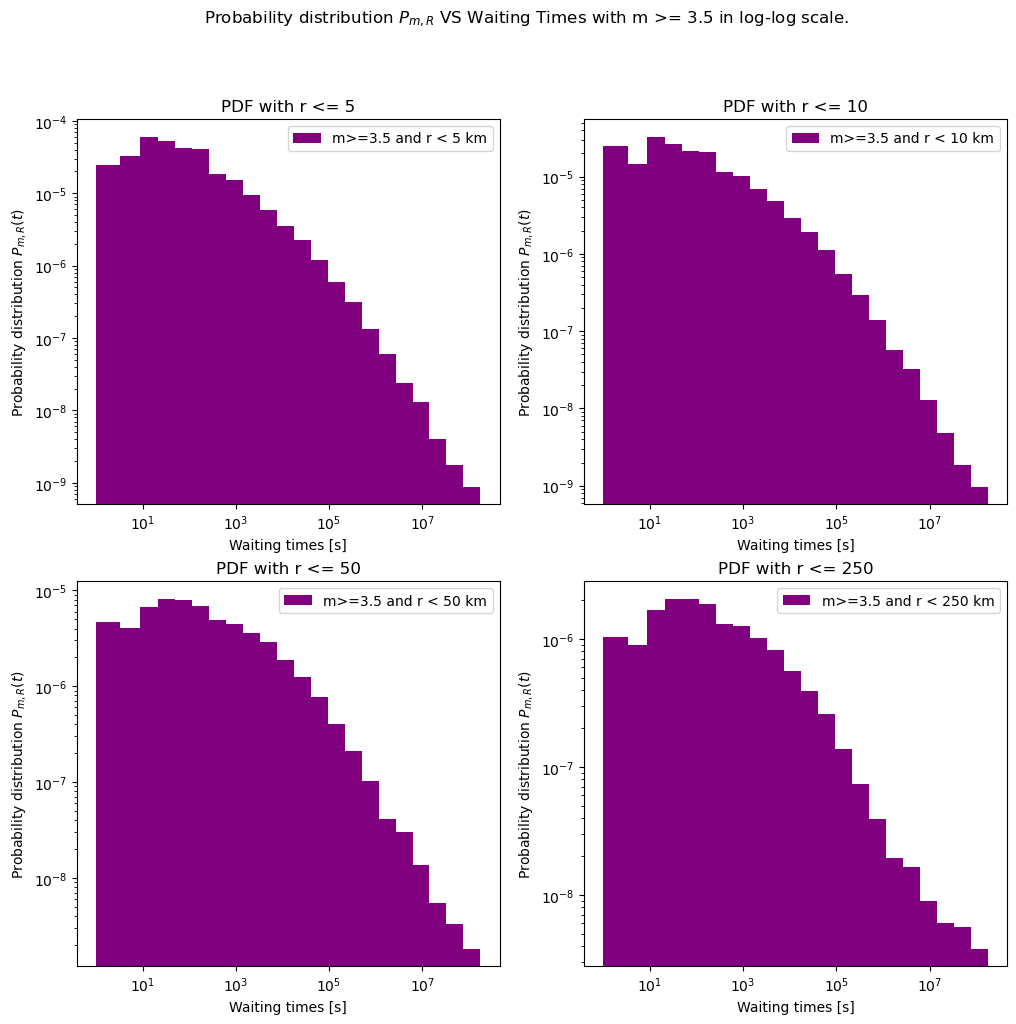

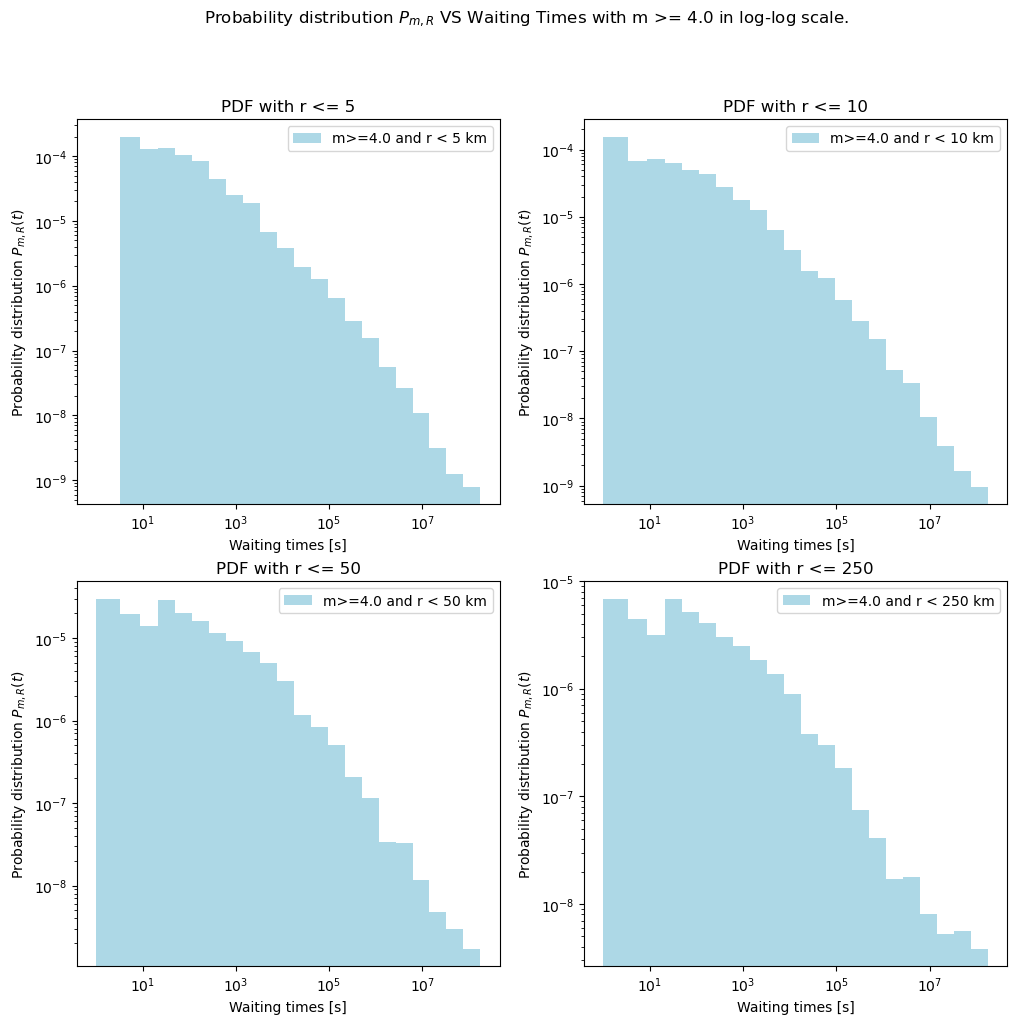

In [34]:
m_vec = np.array([3, 3.5, 4]) 
R_vec = np.array([5, 10, 50, 250])

df_mR_vec = []
rescale_r_vec = []
rescale_r_vec_1 = []

for m in m_vec:

    c = 0
    # DataFrame in which we will save all entries characterized by the WaitingTimes characterized by m >= M and with r < R
    df_filtered_copy = copy.deepcopy(df[df['Magnitude'] >= m]) # Earthquakes with magnitude m or above
    print("\n\nThe number of earthquakes with a magnitude m >= " + str(m) + " is: ", df_filtered_copy.shape[0])

    df_filtered_mR = pd.DataFrame()
    df_filtered_mR['Time'] = df_filtered_copy['Time']
    df_filtered_mR = df_filtered_mR.dropna() # get rid of NaN

    fig, ax_vec = plt.subplots(nrows=2, ncols=2, figsize=(12,11))
    fig.suptitle("Probability distribution $P_{m, R}$ VS Waiting Times with m >= " + str(m) + " in log-log scale.")

    for r in range(len(R_vec)):

        df_Waiting_Times = pd.DataFrame()
        
        print("\n\nRadius r < " + str(R_vec[r]))
        for main_entry in range(df_filtered_mR.shape[0]): # at each iteration e, we take the e-th entry as a reference earthquake and we compute the distance with respect to the other earthquakes and the waiting times

            # xyz coordinates of the earthquakes that we are considering
            x_main = df_filtered_copy['x'].iloc[main_entry]
            y_main = df_filtered_copy['y'].iloc[main_entry]
            z_main = df_filtered_copy['z'].iloc[main_entry]

            df_filtered_mR['WaitingTimes_entry'] = np.zeros(df_filtered_copy.shape[0]) # add a new column

            # time at which main_entry occures
            main_time = df_filtered_mR['Time'].iloc[main_entry]

            # initialize all the values to zero
            df_filtered_mR['x_distance_entry'] = np.zeros(df_filtered_mR.shape[0])
            df_filtered_mR['y_distance_entry'] = np.zeros(df_filtered_mR.shape[0])
            df_filtered_mR['z_distance_entry'] = np.zeros(df_filtered_mR.shape[0])
            df_filtered_mR['xyz_distance_entry'] = np.zeros(df_filtered_mR.shape[0])

            # Compute the distance betweeen the main_entry and the n-th entry
            df_filtered_mR['x_distance_entry'] = x_main - (df_filtered_copy['x']) # +'e_'+str(e)
            df_filtered_mR['y_distance_entry'] = y_main - (df_filtered_copy['y'])
            df_filtered_mR['z_distance_entry'] = z_main - (df_filtered_copy['z'])

            # compute Euclidean distance in km
            xyz_distance = np.sqrt((df_filtered_mR['x_distance_entry'])**2 +(df_filtered_mR['y_distance_entry'])**2 +(df_filtered_mR['z_distance_entry'])**2)/1000

            df_filtered_mR['xyz_distance_entry'] = xyz_distance

            # prepare DataFrame for WaitingTimes
            df_filtered_mR['WaitingTimes_entry'] = np.abs(df_filtered_copy['Time'] - main_time) # fill the new column with Waiting Times

            # cleaning data           
            df_entry = df_filtered_mR[df_filtered_mR['xyz_distance_entry'] <= R_vec[r]]
            df_entry = df_entry[df_entry['xyz_distance_entry'] > 0]
            df_entry = df_entry.dropna(axis=0, how='all') # get rid of NaN

            if main_entry % 1000 == 0 and df_entry.empty == False:
                print("\nThe eathquake central entry w.r.t. which are computing the distance is: " + str(main_entry) + " / " + str(df_filtered_mR.shape[0]))
                print("With central entry " + str(main_entry) + " and with r <= " + str(R_vec[r]) + ", the max distance is " + str(round(df_entry['xyz_distance_entry'].max(), 2)) + " km.") #, df_entry[xyz_distance].max())

            c += df_entry['WaitingTimes_entry'].shape[0]
            df_Waiting_Times = pd.concat([df_Waiting_Times, df_entry['WaitingTimes_entry']]) # df_entry will contain a DataFrame whose WaitingTimes_entry 

            df_filtered_mR = df_filtered_mR.dropna() # get rid of NaN
            df_mR_vec.append(df_filtered_mR)
        # End main cycle

        print("\nFor r < " + str(R_vec[r]) + ",  we have counted " + str(c))
        print("c = ", c)
        width = np.logspace(0, 8, 23)
        edges = np.cumsum(width)

        if r <= 1:
            ax = ax_vec[0, np.mod(r,2)]
        else:
            ax = ax_vec[1, np.mod(r,2)]

        if m == 3.5:
            color = "purple"
        elif m == 4:
            color = 'lightblue'
        else:
            color = 'green'

        ax.hist(df_Waiting_Times, bins = edges, density = True, color= color, label = 'm>=' + str(m) + " and r < " + str(R_vec[r]) + " km")
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_xlabel('Waiting times [s]')
        ax.set_ylabel('Probability distribution $P_{m, R}(t)$')
        ax.set_title('PDF with r <= ' + str(R_vec[r]))
        ax.legend()

        plt.figure()
        hist_output = plt.hist(df_Waiting_Times, bins = edges, density = True, color= color, label = 'm>=' + str(m) + " and r < " + str(R_vec[r]) + " km")
        plt.close()

        if m == 3.5:
            rescale_r_vec.append(hist_output)
        elif m ==4:
            rescale_r_vec_1.append(hist_output)

    print(df_Waiting_Times.shape)
    print(c)

print(df_filtered_mR[0:3])

In order to rescale the function with different values of $m$ and $r$, first we divided the counts of the histogram for the area of the histogram and we multiplied by the square root of $r$.

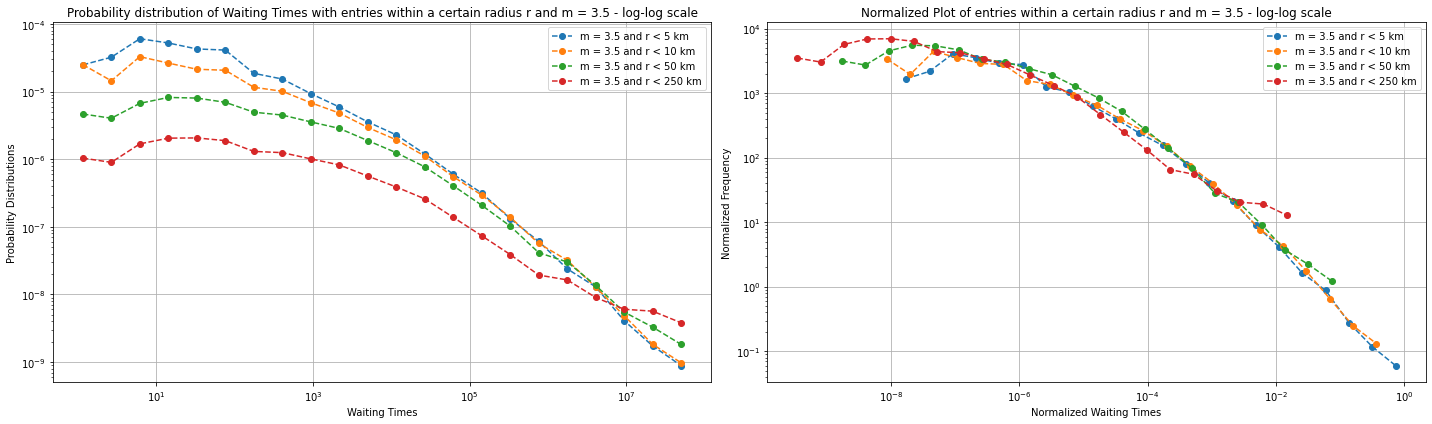

In [96]:
fig, axs = plt.subplots(1, 2, figsize=(20,6))  # Creates a figure with two subplots

for i in range(0, 4):
    bins = rescale_r_vec[i][1]
    x_centers = (bins[1:] - bins[:-1])/2
    bin_width = bins[1:] - bins[0:-1] 
    mean_r = rescale_r_vec[i][1].mean()
    axs[0].plot(x_centers, rescale_r_vec[i][0], 'o--', label= "m = 3.5 and r < " + str(R_vec[i]) + str(" km"))

axs[0].set_title("Probability distribution of Waiting Times with entries within a certain radius r and m = 3.5 - log-log scale")
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].set_xlabel('Waiting Times')
axs[0].set_ylabel('Probability Distributions')
axs[0].legend()
axs[0].grid()

for i in range(0, 4):
    bins = rescale_r_vec[i][1]
    x_centers = (bins[1:] - bins[:-1])/2
    bin_width = bins[1:] - bins[0:-1] 
    mean_r = rescale_r_vec[i][1].mean()
    axs[1].plot(x_centers/(mean_r*(R_vec[i])), rescale_r_vec[i][0]*(mean_r*(R_vec[i])), 'o--', label= "m = 3.5 and r < " + str(R_vec[i]) + str(" km"))

axs[1].set_title("Normalized Plot of entries within a certain radius r and m = 3.5 - log-log scale")
axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].set_xlabel('Normalized Waiting Times')
axs[1].set_ylabel('Normalized Frequency')
axs[1].legend()
axs[1].grid()

plt.tight_layout()
plt.show()
